In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import json
import seaborn as sns
import re
import warnings
from IPython.display import Image
import networkx as nx
import pingparsing
warnings.filterwarnings('ignore')
import random

In [2]:
SITES = ['lille', 'paris', 'nancy', 'rennes', 'nantes', 'lyon', 'grenoble', 'toulouse', 'marseille', 'nice']
POS = {'lille': (450, -40), 'paris': (410, -180), 'nancy': (720, -180), 'rennes': (140, -220), 'nantes': (160, -300), 'lyon': (550, -530), 'grenoble': (610, -600), 'toulouse': (270, -760), 'marseille': (570, -800), 'nice': (710, -770)}
# SWITCHES = {'s1': 'lille', 's12': 'paris', 's23': 'nancy', 's34': 'rennes', 's45': 'nantes', 's56': 'lyon', 's67': 'grenoble', 's78': 'toulouse', 's89': 'marseille', 's100': 'nice'}
# LINKS = {'s1-eth11--s12-eth11': ('lille', 'paris'), 's12-eth12--s23-eth11': ('paris', 'nancy'), 's12-eth13--s34-eth11': ('paris', 'rennes'), 's12-eth14--s56-eth11': ('paris', 'lyon'), 's34-eth12--s45-eth11': ('rennes', 'nantes'), 's56-eth12--s67-eth11': ('lyon', 'grenoble'), 's56-eth13--s89-eth11': ('lyon', 'marseille'), 's78-eth11--s89-eth12': ('toulouse', 'marseille'), 's89-eth13--s100-eth11': ('marseille', 'nice')}

In [3]:
def get_switches(link):
    [end1, end2] = link.split('--')
    sw1 = end1.split('-')[0]
    sw2 = end2.split('-')[0]
    return (SWITCHES[sw1], SWITCHES[sw2])

In [4]:
def parse_log(filename):
    try:
        with open(filename, 'r') as f:
            raw = f.read()
            data = json.loads(raw)
            dt = data['end']['sum_sent']['seconds']
            th = data['end']['sum_sent']['bits_per_second'] / 1000000
            return dt, th
    except:
        print("No data for " + filename)
        return None, None

def parse_chrono(filename):
    with open(filename, 'r') as f:
        t1 = int(f.readline()[:-1])
        t2 = int(f.readline()[:-1])
    return t1, t2

def parse_flow(filename, t0):
    try:
        with open(filename, 'r') as f:
            raw = f.read()
            data = json.loads(raw)
        ts, ths = [], []
        for interval in data['intervals']:
            t = interval['sum']['end'] + t0
            if t < 0:
                print(filename)
            th = interval['sum']['bits_per_second'] / 1000000
            ts.append(t)
            ths.append(th)
        return ts, ths
    
    except:
        print("No data for " + filename)
        return None, None

# def parse_ping(filename):
#     with open(filename, 'r') as f:
#         raw = 

In [5]:
def joint_clean(xs, ys, inf=5, sup=95):
    inf, sup = np.percentile(xs, inf), np.percentile(xs, sup)
    indices = [i for i in range(len(xs)) if xs[i] >= inf and xs[i] <= sup]
    xs = [xs[i] for i in indices]
    ys = [ys[i] for i in indices]
    return xs, ys

def clean(xs, inf=5, sup=95):
    inf, sup = np.percentile(xs, inf), np.percentile(xs, sup)
    xs = [x for x in xs if x >= inf and x <= sup]
    return xs

def parse_mon(filename, inf=5, sup=95):
    with open(filename, 'r') as f:
        raw = f.read()
        data = json.loads(raw)
    rtds, rtds_ = joint_clean(data['rtds'], data['rtds_'], inf, sup)
    return rtds, rtds_

def abs_error(xs, ys):
    return [abs(xs[i]-ys[i]) for i in range(len(xs))]

def rel_error(xs, ys):
    return [abs(xs[i]-ys[i])*100/ys[i] for i in range(len(xs))]

def diff_error(xs, ys):
    return [xs[i]-ys[i] for i in range(len(xs))]

# abs_error = diff_error

In [6]:
def parse_metadata(filename):
    with open(filename, 'r') as f:
        raw = f.read()
        metadata = json.loads(raw)
    return metadata

def parameters(metadata):
    site = list(metadata['hosts'].keys())[0]
    n = len(metadata['hosts'][site])
    m = len(metadata['hosts'][site][0])
    p = len(metadata['hosts'].keys())
    return n, m, p

In [7]:
def asynchronisation(path):
    metadata = parse_metadata(path + 'metadata')
    n, m, p = parameters(metadata)
    N = 10*n*m
    ts = []
    for i in range(N//2):
        filename = path + "client_%i.chrono" % (2*i+1)
        with open(filename, 'r') as f:
            t = int(f.readline()[:-1])
            f.close()
        ts.append(t)
    print("Asynchronisation level: %.2f seconds" % np.std(ts))

In [8]:
def get_site(path, site):
    metadata = parse_metadata(path + 'metadata')
    clients = []
    for access in metadata['hosts'][site]:
        for h in access:
            i = int(h[1:])
            if i % 2 == 1:
                clients.append(i)
    
    dts = []
    ths = []
    for i in clients:
        filename = path + "client_%i.iperf" % i
        dt, th = parse_log(filename)
        if dt is not None:
            dts.append(dt)
            ths.append(th)
            
    return dts, ths

def get_join_sites(path, site1, site2):
    random.seed(100)
    metadata = parse_metadata(path + 'metadata')
    n, m, p = parameters(metadata)
    N = n*m*p
    
    indices = list(range(N//2))
    clients = [2*i+1 for i in indices]
    random.shuffle(indices)
    servers = [2*i+2 for i in indices]
    
    dts, ths = [], []
    for i in range(N//2):
        client, server = clients[i], servers[i]
        x, y = int((client-1)/(n*m)), int((server-1)/(n*m))
        source, destination = SITES[x], SITES[y]
        if source == site1 and destination == site2:
            filename = path + "client_%i.iperf" % client
            dt, th = parse_log(filename)
            if dt is not None:
                dts.append(dt)
                ths.append(th)
    
    return dts, ths

In [9]:
def plot_core(path, inf=5, sup=95):
    metadata = parse_metadata(path + 'metadata')
    abs_errs = []
    rel_errs = []
    links = metadata['links']['core']
    for linkname in links:
        try:
            filename = path + linkname
            rtds, rtds_ = parse_mon(filename, inf=inf, sup=sup)
            abs_err, rel_err = abs_error(rtds, rtds_), rel_error(rtds, rtds_)
            plt.subplot(1, 2, 1)
            sns.ecdfplot(rel_err)
            plt.subplot(1, 2, 2)
            sns.ecdfplot(abs_err)
            abs_errs.extend(abs_err)
            rel_errs.extend(rel_err)
        except:
            continue
    plt.subplot(1, 2, 1)
    plt.xlabel('Percentage Absolute Error (%)')
    plt.subplot(1, 2, 2)
    plt.xlabel('Absolute Error (ms)')
    plt.show()
    print("50th percentile of PAE: %.2f %%" % np.percentile(rel_errs, 50))
    print("50th percentile of  AE: %.2f ms" % np.percentile(abs_errs, 50))

In [10]:
# def analyse(path, inf=0, sup=100, p=50):
#     metadata = parse_metadata(path + 'metadata')
#     dss1, dss2 = {}, {}
#     sites = list(metadata['hosts'].keys())
#     for site in sites:
#         ds1, ds2 = get_site(path, site)
#         dss1[site], dss2[site] = ds1, ds2
#     data1, labels = list(dss1.values()), list(dss1.keys())
#     data2, labels = list(dss2.values()), list(dss2.keys())
    
#     plt.boxplot(data2, labels=labels, showfliers=False)
#     plt.ylabel("Duration (s)")
#     plt.title("Download durations per site")
#     plt.show()
    
#     plt.boxplot(data1, labels=labels, showfliers=False)
#     plt.ylabel("Duration (s)")
#     plt.title("Total durations per site")
#     plt.show()
    
#     m1 = np.mean([np.mean(dss1[site]) for site in dss1])
#     m2 = np.mean([np.mean(dss2[site]) for site in dss2])
#     print("Mean download duration: %.3f seconds" % m2)
#     print("Mean   total  duration: %.3f seconds" % m1)
    
#     plt.figure(figsize=(8, 8))
#     errs = {}
#     for linkname in LINKS:
#         filename = path + linkname
#         rtds, rtds_ = parse_mon(filename, inf=inf, sup=sup)
#         abs_err, rel_err = abs_error(rtds, rtds_), rel_error(rtds, rtds_)
#         errs[LINKS[linkname]] = "%.2f %%" % np.percentile(rel_err, p)
#         # errs[LINKS[linkname]] = "%i" % len(rel_err)
    
#     G = nx.Graph()
#     for site in SITES:
#         G.add_node(site)
#     for link in LINKS:
#         G.add_edge(*LINKS[link])
#     nx.draw(G, POS, with_labels=True, node_size=1000, node_color='white')
#     nx.draw_networkx_edge_labels(G, POS, edge_labels=errs, font_color='red', rotate=False)
    
    

In [11]:
# def parse_iperf(filename):
#     with open(filename, 'r') as f:
#         raw = f.read()
#         data = json.loads(raw)
#     ths = []
#     for interval in data['intervals']:
#         th = interval['sum']['bits_per_second']
#         ths.append(th)
#     return ths

# def parse_ping(filename):
#     parser = pingparsing.PingParsing()
#     with open(filename, 'r') as f:
#         raw = f.read()
#         stats = parser.parse(raw)
#     rtts = []
#     for icmp in stats.icmp_replies:
#         rtt = icmp['time']
#         rtts.append(rtt)
#     return rtts

In [159]:
erss = []

In [160]:
def map_data(path, mode='rel', q=50, inf=5, sup=95, factor=1):
    metadata = parse_metadata(path + 'metadata')
    n, m, p = parameters(metadata)
    sites_switches = {SITES[i]: 's%i' % (i*(n+1)+1) for i in range(p)}
    switches_sites = {'s%i' % (i*(n+1)+1): SITES[i] for i in range(p)}
    print(sites_switches)
    def sites_link(link):
        [intf1, intf2] = link.split('--')
        s1 = intf1.split('-')[0]
        s2 = intf2.split('-')[0]
        return switches_sites[s1], switches_sites[s2]
    
    plt.figure(figsize=(8*factor, 8*factor))
    errs = {}
    for linkname in metadata['links']['core']:
        filename = path + linkname
        pair = sites_link(linkname)
        
        try:
            rtds, rtds_ = parse_mon(filename, inf=inf, sup=sup)
            if mode == 'rel':
                rel_err = rel_error(rtds, rtds_)
                errs[pair] = "%.2f %%" % np.percentile(rel_err, q)
            elif mode == 'abs':
                abs_err = abs_error(rtds, rtds_)
                errs[pair] = "%.2f ms" % np.percentile(abs_err, q)
                
        except:
            errs[pair] = "N/A"
            
        # errs[LINKS[linkname]] = "%i" % len(rel_err)
    
    erss.append(errs)
    
    G = nx.Graph()
    for site in SITES:
        G.add_node(site)
    for linkname in metadata['links']['core']:
        pair = sites_link(linkname)
        G.add_edge(*pair)
    # pos = {site: (POS[site][0]*factor, POS[site][1]*factor) for site in POS}
    nx.draw(G, POS, with_labels=True, node_size=1000, node_color='white')
    nx.draw_networkx_edge_labels(G, POS, edge_labels=errs, font_color='red', rotate=False)
    
    plt.savefig(path + 'map.png')
    
    

In [161]:
dtss = []

In [162]:
def view_iperfs(path, norm=None):
    # plt.figure(figsize=(8, 4))
    metadata = parse_metadata(path + 'metadata')
    iperfs = {site: get_site(path, site)[0] for site in SITES}
    dts, labels = list(iperfs.values()), list(iperfs.keys())
    dtss.append(dts)
    # plt.boxplot(dts, labels=labels, showfliers=False)
    # plt.ylabel("Duration (s)")
    # plt.title("Download durations per site")
    # plt.show()
    
    # plt.figure(figsize=(8, 4))
    # iperfs = {site: get_site(path, site)[1] for site in SITES}
    # ths, labels = list(iperfs.values()), list(iperfs.keys())
    # plt.boxplot(ths, labels=labels, showfliers=False)
    # plt.ylabel("Throughput (Mbps)")
    # plt.title("Average throughputs per site")
    # plt.show()
    
    random.seed(100)
    plt.figure(figsize=(5, 4))
    metadata = parse_metadata(path + 'metadata')
    iperfs = {(site1, site2): np.mean(get_join_sites(path, site1, site2)[0]) for site1 in SITES for site2 in SITES}
    data = np.array([[iperfs[(SITES[i], SITES[j])] for j in range(10)] for i in range(10)])
    # cmap = colors.LinearSegmentedColormap('GnRd', cdict)
    im = plt.imshow(data, cmap='summer', norm=norm)
    plt.colorbar()
    plt.xticks(list(range(10)), labels=SITES)
    plt.yticks(list(range(10)), labels=SITES)
    plt.setp(plt.xticks()[1], rotation=45, ha="right", rotation_mode="anchor")
    plt.savefig(path + 'cdfs.png', bbox_inches='tight')
    plt.show()
    mu = np.mean([x for dt in dts for x in dt])
    sd = np.std([x for dt in dts for x in dt])
    tot = max([x for dt in dts for x in dt])
    print("Result: %.2f s +/- %.2f (max = %.2f s)" % (mu, sd, tot))
    
    return im

def view_flows(path):
    plt.figure(figsize=(8, 4))
    metadata = parse_metadata(path + 'metadata')
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    c = 0
    for site in SITES:
        color = colors[c]
        c += 1
        
        for access in metadata['hosts'][site]:
            for h in access:
                i = int(h[1:])
                if i % 2 == 1:
                    t0, _ = parse_chrono(path + "client_%i.chrono" % i)
                    ts, ths = parse_flow(path + "client_%i.iperf" % i, t0)
                    plt.plot(ts, ths, color=color)
    plt.show()

Asynchronisation level: 0.36 seconds
{'lille': 's1', 'paris': 's7', 'nancy': 's13', 'rennes': 's19', 'nantes': 's25', 'lyon': 's31', 'grenoble': 's37', 'toulouse': 's43', 'marseille': 's49', 'nice': 's55'}


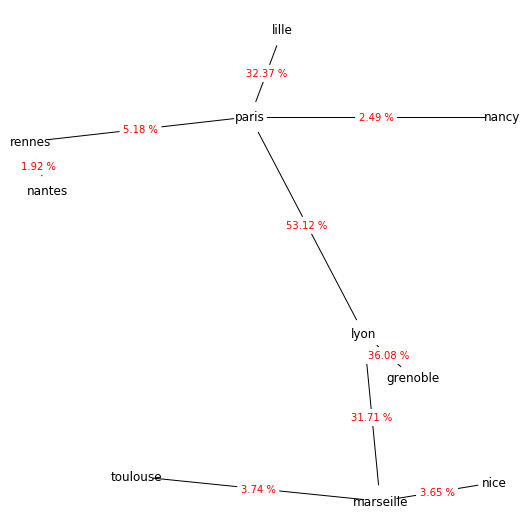

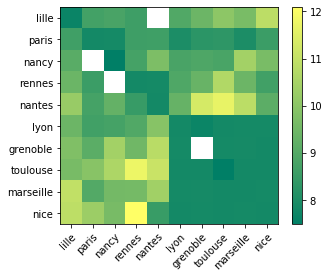

Result: 9.05 s +/- 1.31 (max = 14.35 s)


In [163]:
path = "run1/"
asynchronisation(path)
map_data(path, mode='rel', q=90, inf=0, sup=100, factor=0.9)
im1 = view_iperfs(path)

Asynchronisation level: 0.35 seconds
{'lille': 's1', 'paris': 's7', 'nancy': 's13', 'rennes': 's19', 'nantes': 's25', 'lyon': 's31', 'grenoble': 's37', 'toulouse': 's43', 'marseille': 's49', 'nice': 's55'}


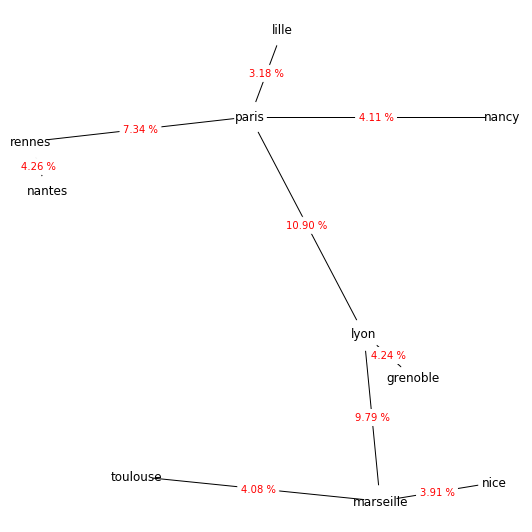

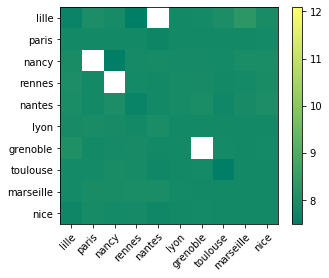

Result: 7.90 s +/- 0.17 (max = 9.91 s)


In [164]:
path = "run0/"
asynchronisation(path)
map_data(path, mode='rel', q=90, inf=0, sup=100, factor=0.9)
im0 = view_iperfs(path, im1.norm)

In [165]:
im0.cmap(im0.norm(100))

(1.0, 1.0, 0.4, 1.0)

In [166]:
dtsss = [[], []]
for i in range(10):
    dtsss[1].extend(dtss[0][i])
    dtsss[0].extend(dtss[1][i])


In [167]:
erss[0] = list(erss[0].values())
erss[1] = list(erss[1].values())
erss = [erss[1], erss[0]]
for i in range(9):
    erss[0][i] = float(erss[0][i][:-2])
    erss[1][i] = float(erss[1][i][:-2])

In [168]:
erss

[[3.18, 4.11, 7.34, 10.9, 4.26, 4.24, 9.79, 4.08, 3.91],
 [32.37, 2.49, 5.18, 53.12, 1.92, 36.08, 31.71, 3.74, 3.65]]

Text(0, 0.5, 'FCT (s)')

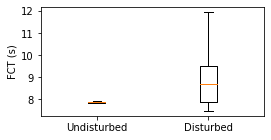

In [121]:
plt.figure(figsize=(4, 2))
plt.boxplot(dtsss, labels=['Undisturbed', 'Disturbed'], showfliers=False)
plt.ylabel("FCT (s)")

([<matplotlib.axis.XTick at 0x7ff1ed5f6550>,
 <a list of 2 Text xticklabel objects>)

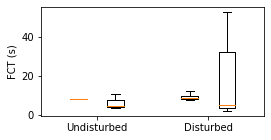

In [172]:
plt.figure(figsize=(4, 2))
# plt.boxplot([[], []], labels=['Undisturbed', 'Disturbed'], positions=[1, 3])
plt.boxplot(dtsss, showfliers=False, positions=[0.5, 2])
plt.boxplot(erss, showfliers=False, positions=[1, 2.5])
plt.ylabel("FCT (s)")
plt.xticks([0.75, 2.25], ['Undisturbed', 'Disturbed'])

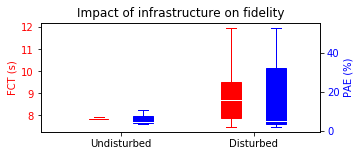

In [204]:
fig, ax1 = plt.subplots()
fig.set_figheight(2)
fig.set_figwidth(5)

ax2 = ax1.twinx()
c = 'r'
ax1.boxplot(dtsss, showfliers=False, positions=[0.5, 2], patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='w'),
            )
ax1.tick_params(axis='y', labelcolor=c)
c = 'b'
ax2.boxplot(erss, showfliers=False, positions=[1, 2.5], patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='w'),
            )
ax2.tick_params(axis='y', labelcolor=c)

plt.xticks([0.75, 2.25], ['Undisturbed', 'Disturbed'])
ax1.set_ylabel('FCT (s)', color='r')
ax2.set_ylabel('PAE (%)', color='b')

plt.title("Impact of infrastructure on fidelity")

plt.savefig(path + 'fig.png', bbox_inches='tight', dpi=1000)
# plt.grid()
plt.show()

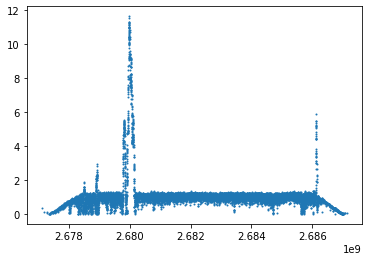

In [35]:
# Paris-Lyon
with open("debug2/s7-eth9--s31-eth6", 'r') as f:
    raw = f.read()
    data = json.loads(raw)
    f.close()
tss1, tss2, rtds, rtds_ = data['tss1'], data['tss2'], data['rtds'], data['rtds_']
sizes, holsizes, qsizes, taus = data['lens'], data['plens'], data['blens'], data['taus']
rel_err, abs_err, diff_err = rel_error(rtds, rtds_), abs_error(rtds, rtds_), diff_error(rtds, rtds_)
plt.scatter(tss1, abs_err, 1)

In [19]:
len(sizes)

1919

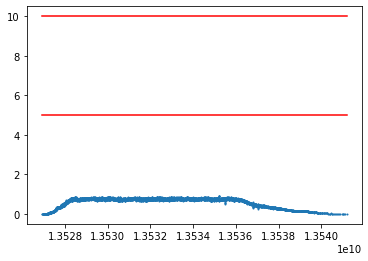

In [93]:
rtds__ = np.array(qsizes) / 5e6
plt.scatter(tss1, rtds__, 1)
plt.plot([tss1[0], tss1[-1]], [5, 5], color='red')
plt.plot([tss1[0], tss1[-1]], [10, 10], color='red')
# plt.yscale('log')

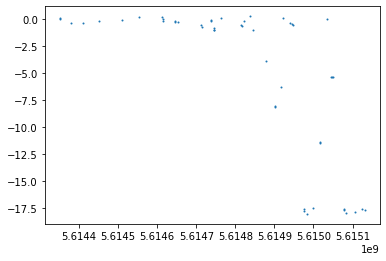

In [84]:
# Paris-Lyon
with open("debug5/s3-eth5--s11-eth2", 'r') as f:
    raw = f.read()
    data = json.loads(raw)
    f.close()
tss1, tss2, rtds, rtds_ = data['tss1'], data['tss2'], data['rtds'], data['rtds_']
sizes, holsizes, qsizes, taus = data['lens'], data['plens'], data['blens'], data['taus']
rel_err, abs_err, diff_err = rel_error(rtds, rtds_), abs_error(rtds, rtds_), diff_error(rtds, rtds_)
plt.scatter(tss1[:50], abs_err[:50], 1)

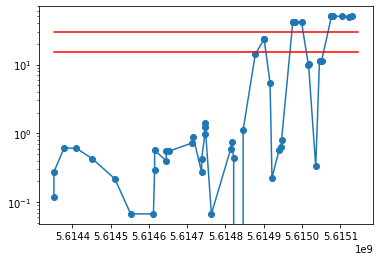

In [85]:
rtds__ = np.array(qsizes) / 5e3
plt.plot(tss1[:50], rtds__[:50], 'o-')
plt.plot([tss1[0], tss1[50]], [15, 15], color='red')
plt.plot([tss1[0], tss1[50]], [30, 30], color='red')
plt.yscale('log')

In [23]:
metadata = parse_metadata('debug5/metadata')
errors = []
sizess, holsizess, qsizess, tauss = [], [], [], []
for linkname in metadata['links']['core']:
    filename = 'debug5/' + linkname
    with open(filename, 'r') as f:
        raw = f.read()
        data = json.loads(raw)
        tss1, tss2 = data['tss1'], data['tss2']
        rtds, rtds_ = data['rtds'], data['rtds_']
        sizes, holsizes, qsizes, taus = data['lens'], data['plens'], data['blens'], data['taus']
        diff_err = diff_error(rtds, rtds_)
        size, holsize, qsize, tau = np.percentile(sizes, 90), np.percentile(holsizes, 90), np.percentile(qsizes, 90), np.percentile(taus, 90)
        error = np.percentile(diff_err, 90)
        sizess.append(size)
        holsizess.append(holsize)
        qsizess.append(qsize)
        tauss.append(tau)
        errors.append(error)

In [25]:
np.corrcoef([errors, holsizess, qsizess, tauss])

array([[ 1.        , -0.34061341, -0.40744017, -0.57038337],
       [-0.34061341,  1.        , -0.09908704,  0.72818153],
       [-0.40744017, -0.09908704,  1.        ,  0.14790443],
       [-0.57038337,  0.72818153,  0.14790443,  1.        ]])

In [16]:
lens, plens, blens, taus = data['lens'], data['plens'], data['blens'], data['taus']

KeyError: 'lens'

In [20]:
diff_err = diff_error(rtds, rtds_)

In [44]:
rtds__ = []
for i in range(len(lens)):
    size, plen, blen, tau = 

array([[ 1.        , -0.68035238, -0.37903918, -0.12407585],
       [-0.68035238,  1.        ,  0.21753996,  0.04813218],
       [-0.37903918,  0.21753996,  1.        ,  0.260966  ],
       [-0.12407585,  0.04813218,  0.260966  ,  1.        ]])

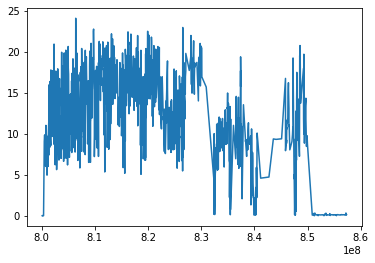

In [50]:
# Lyon-Grenoble
with open("debug2/s11-eth3--s13-eth2", 'r') as f:
    raw = f.read()
    data = json.loads(raw)
    f.close()
tss1, tss2, rtds, rtds_ = data['tss1'], data['tss2'], data['rtds'], data['rtds_']
rel_err, abs_err = rel_error(rtds, rtds_), abs_error(rtds, rtds_)
plt.plot(tss2, abs_err)

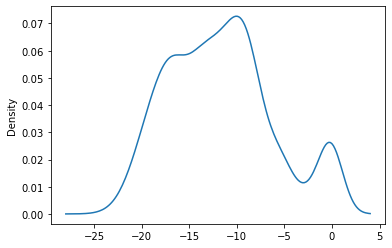

In [55]:
diff_err = diff_error(rtds, rtds_)
sns.kdeplot(diff_err)

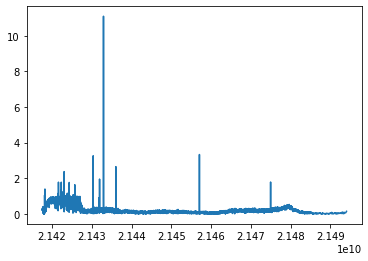

In [36]:
# Rennes-Nantes
with open("tcprun4/s19-eth7--s25-eth6", 'r') as f:
    raw = f.read()
    data = json.loads(raw)
    f.close()
tss1, tss2, rtds, rtds_ = data['tss1'], data['tss2'], data['rtds'], data['rtds_']
rel_err, abs_err = rel_error(rtds, rtds_), abs_error(rtds, rtds_)
plt.plot(tss2, abs_err)

In [ ]:
view_flows(path)

In [ ]:
ts, ths = parse_flow('pingrun5/client_95.iperf

In [38]:
with open('exorun5/metadata2', 'r') as f:
    raw = f.read()
    metadata = json.loads(raw)
metadata['workers']

['172.16.96.10',
 '172.16.96.11',
 '172.16.96.15',
 '172.16.96.40',
 '172.16.96.43',
 '172.16.100.1',
 '172.16.100.2',
 '172.16.100.3',
 '172.16.100.4',
 '172.16.100.5']

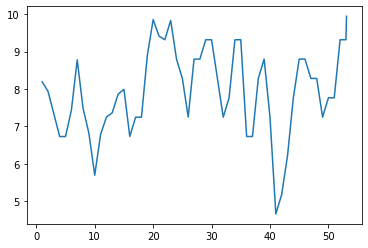

In [17]:
rtds, rtds_ = plt.plot(ts, ths)

In [25]:
rtds, rtds_ = parse_mon('selectrun-1/s43-eth6--s49-eth7')

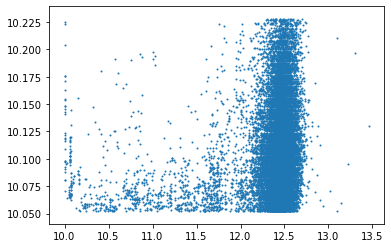

In [26]:
plt.scatter(rtds_, rtds, 1)

In [46]:
file = open('debug1/s43-eth6--s49-eth7', 'r')
raw = file.read()
data = json.loads(raw)

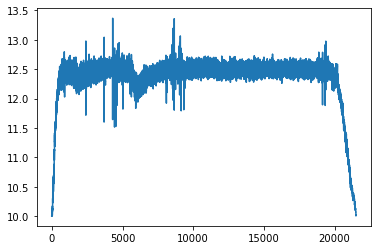

In [47]:
plt.plot(data['rtds_'])

In [55]:
min(data['rtds_'])

10.00216

In [57]:
2160/16

135.0

In [60]:
max(data['blens'])/16

209813.0